IS6400 21/22 Semester B

- Week 6: Regression (Solution to the exercise)

Zhiya Zuo (zhiyazuo@cityu.edu.hk)

Department of Information Systems

City University of Hong Kong

---

In [1]:
from itertools import combinations, product

In [2]:
import numpy as np
from scipy import stats as SP_STATS
import pandas as pd

In [3]:
from sklearn import linear_model
from sklearn import gaussian_process as SK_GP
from sklearn import metrics
from sklearn.model_selection import KFold

In [4]:
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import cm
#%matplotlib notebook
%matplotlib inline

---

# The question

Please use the [insurance charge data](https://www.kaggle.com/mirichoi0218/insurance) for multivariate regression using:
1. Linear regression without regularization
2. Linear regression with L2 norm regulariaztion (ridge regression)
3. Gaussian Process regression.

You are expected to:
- Use mean square error (MSE) as the evaluation metric.
- Hold out a random set of 20% data as the test set.
- Apply a 5-fold cross validation with the remaining data.
- Summarize the prediction results (both errors on the training and testing data).

---

# Check out the data

Whenever we do data analysis, the first step is always to check out the data instead of directly going into the analysis.

In [5]:
data = pd.read_csv('insurance.csv')
data.head(2)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523


Drop the region column for simplicity

In [6]:
data.drop(columns=['region'], inplace=True)

Convert `sex` and `smoker` from text into binary variables

In [7]:
data['sex'].unique()

array(['female', 'male'], dtype=object)

In [8]:
data['sex'] = data['sex'].map({'female': 1, 'male': 0})

In [9]:
data['smoker'].unique()

array(['yes', 'no'], dtype=object)

In [10]:
data['smoker'] = data['smoker'].map({'yes': 1, 'no': 0})

Check if any missing values

In [11]:
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
charges     0
dtype: int64

Check out the distribution in case there is any outlier.

In [12]:
data.describe().round(3)

,age,sex,bmi,children,smoker,charges
count,1338.000,1338.000,1338.000,1338.000,1338.000,1338.000
mean,39.207,0.495,30.663,1.095,0.205,13270.422
std,14.050,0.500,6.098,1.205,0.404,12110.011
min,18.000,0.000,15.960,0.000,0.000,1121.874
25%,27.000,0.000,26.296,0.000,0.000,4740.287
50%,39.000,0.000,30.400,1.000,0.000,9382.033
75%,51.000,1.000,34.694,2.000,0.000,16639.913
max,64.000,1.000,53.130,5.000,1.000,63770.428


Given the small number of features, you could also visualize them

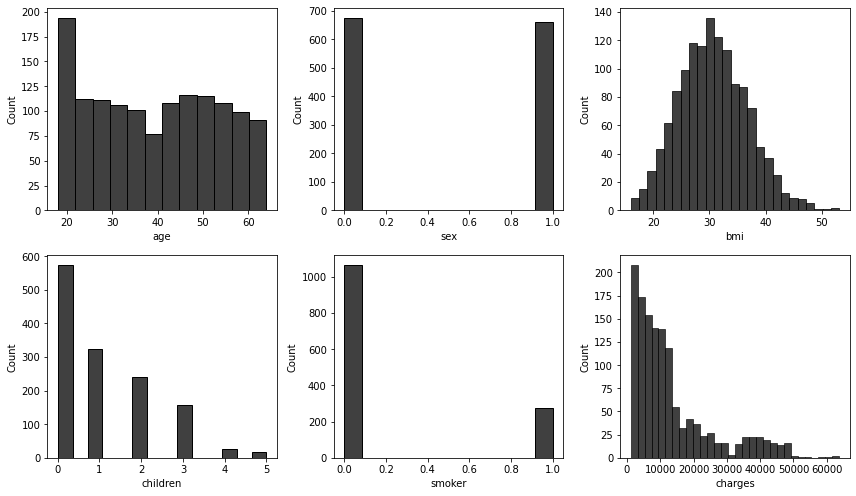

In [13]:
num_rows, num_cols = 2, 3
figsize = [num_cols*4, num_rows*3.5]
fig, ax_arr = plt.subplots(figsize=figsize,
                           nrows=num_rows, ncols=num_cols)
for i, col in enumerate(data.columns):
    ax = ax_arr.flat[i]
    sns.histplot(data.loc[:, col], ax=ax, color='k')
fig.tight_layout()

We may try convert the target variable `charges` using a log transformaiton to make it more balanced.

In [14]:
data['charges'] = np.log(data['charges'])

<AxesSubplot:xlabel='charges', ylabel='Count'>

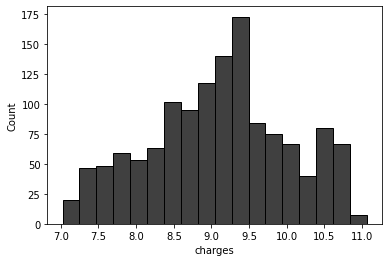

In [15]:
fig, ax = plt.subplots(figsize=[6, 4])
sns.histplot(data['charges'], ax=ax, color='k')

---

# Now let's predict

## Prepare data

Use the last 20% as the test set.

In [16]:
N = data.shape[0]
N_train = int(N * 0.8)
N_test = N - N_train
print(N, N_train, N_test)

1338 1070 268


Random draw training and testing samples

In [17]:
indices_train = np.random.choice(np.arange(N), replace=False, size=N_train)
indices_test = np.array([index for index in np.arange(N) if index not in indices_train])

In [18]:
data_train = data.iloc[indices_train].copy(deep=True)
data_train.shape

(1070, 6)

In [19]:
data_test = data.iloc[indices_test].copy(deep=True)
data_test.shape

(268, 6)

Split into X and y for convenience later

In [20]:
data_train.columns # double check variable names

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'charges'], dtype='object')

In [21]:
X_train = data_train.loc[:, data_train.columns[:-1]].values
y_train = data_train.loc[:, data_train.columns[-1]].values
X_test = data_test.loc[:, data_test.columns[:-1]].values
y_test = data_test.loc[:, data_test.columns[-1]].values

Set the number of folds to be 5

In [22]:
N_folds = 5

In [23]:
print_string = 'Generalization error across the %i folds: %.3f ± %.3f'

## Linear regression

In [24]:
# use the split for train/validation
kf = KFold(n_splits=N_folds)
mse_list = list()
for i, (tra_index, val_index) in enumerate(kf.split(X_train)):
    X_tra, y_tra = X_train[tra_index], y_train[tra_index]
    X_val, y_val = X_train[val_index], y_train[val_index]
    lr = linear_model.LinearRegression().fit(X_tra, y_tra)
    mse = metrics.mean_squared_error(y_val, lr.predict(X_val))
    mse_list.append(mse)
    print('Fold %i: %.3f'%(i+1, mse))
print(print_string%(N_folds, np.mean(mse_list), np.std(mse_list)))

Fold 1: 0.169
Fold 2: 0.201
Fold 3: 0.241
Fold 4: 0.193
Fold 5: 0.186
Generalization error across the 5 folds: 0.198 ± 0.024


Let's try using all the training data and appply in the test set

In [25]:
lr = linear_model.LinearRegression().fit(X_train, y_train)
lr_mse = metrics.mean_squared_error(y_test, lr.predict(X_test))
print('The overall test error using a linear regression model is %.5f'%(lr_mse))

The overall test error using a linear regression model is 0.21631


## Linear regression with L2 norm regularization

Now that ridge regression contains a hyperparameter, it is also tuned via cross validation. Specifically, the best performing parameter value is picked based on the average performance across folds.

The only hyperparameter is `alpha`, which is the how much regularization one wants to enforce.

In [26]:
alpha_candidates = np.linspace(0.001, 1, 100)

In [27]:
# use the split for train/validation
kf = KFold(n_splits=N_folds)
# let's use a dictionary this time with alpha being key
mse_dict = {alp: list() for alp in alpha_candidates}
for i, (tra_index, val_index) in enumerate(kf.split(X_train)):
    X_tra, y_tra = X_train[tra_index], y_train[tra_index]
    X_val, y_val = X_train[val_index], y_train[val_index]
    for alp in alpha_candidates:
        ridge_alp = linear_model.Ridge(alpha=alp).fit(X_tra, y_tra)
        mse = metrics.mean_squared_error(y_val, ridge_alp.predict(X_val))
        mse_dict[alp].append(mse)

In [28]:
mse_mean_list = np.array([np.mean(mse_alp) for alp, mse_alp in mse_dict.items()])
mse_mean_smallest_alp = sorted(mse_dict.items(), key=lambda x: np.mean(x[1]))[0][0]
mse_mean_smallest_min = np.min(mse_mean_list)
print('Smallest MSE achieved at alpha of %.3f: %.3f'%(mse_mean_smallest_alp,
                                                      mse_mean_smallest_min))

Smallest MSE achieved at alpha of 0.223: 0.198


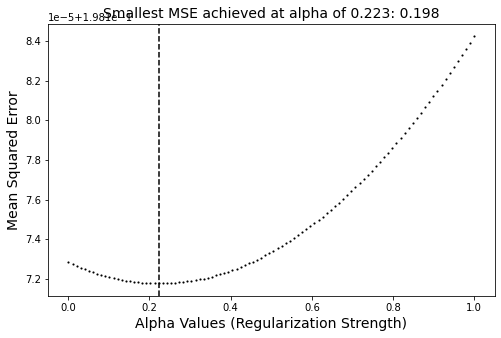

In [29]:
fig, ax = plt.subplots(figsize=[8, 5])
ax.set_ylabel('Mean Squared Error',
              size=14)
ax.set_xlabel('Alpha Values (Regularization Strength)',
              size=14)
ax.axvline(x=mse_mean_smallest_alp, ls='--', color='k')
ax.set_title('Smallest MSE achieved at alpha of %.3f: %.3f'%(mse_mean_smallest_alp,
                                                             mse_mean_smallest_min),
             fontsize=14)
_ = ax.scatter(alpha_candidates, mse_mean_list,
               marker='.', color='k', s=5)

Let's use this best value and train using all the training data.

In [30]:
ridge = linear_model.Ridge(alpha=mse_mean_smallest_alp).fit(X_train, y_train)
ridge_mse = metrics.mean_squared_error(y_test, ridge.predict(X_test))
print('The overall test error using a Ridge regression model is %.5f'%(ridge_mse))

The overall test error using a Ridge regression model is 0.21622


Lastly, note that `sklearn` offers a more convenient function [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV) that helps to conduct cross validation conveniently. You are encouraged to try that on your own.

## Gaussian process regression

Guassian process (GP) regression is much more flexible due to the many choices of kernels which capture distances between data points. In this example, we use the most common one, namely radial-basis function (RBF; a.k.a., squared exponential) kernel. It contains a hyperparameter `length_scale` corresponding to $l$ in the following equation:

$$ RBF(x_i,x_j) = \text{exp}\big( -\dfrac{dist(x_i, x_j)}{2l^2} \big) $$

where $dist(x_i, x_j)$ is a distance measure (a common implementation is Euclidean distance).
The larger $l$ is, the more penalty toward distant data points. For each feature, there is an $l$.

Due to the complexity of this model, we skip the parameter tuning for simplicity and use the default value of $l=1$.

In [31]:
# use the split for train/validation
kf = KFold(n_splits=N_folds)
# let's use a dictionary this time with alpha being key
mse_list = list()
for i, (tra_index, val_index) in enumerate(kf.split(X_train)):
    X_tra, y_tra = X_train[tra_index], y_train[tra_index]
    X_val, y_val = X_train[val_index], y_train[val_index]
    l_kernel = SK_GP.kernels.RBF(length_scale=[1]*X_tra.shape[1])
    gp_l = SK_GP.GaussianProcessRegressor(kernel=l_kernel).fit(X_tra, y_tra)
    mse = metrics.mean_squared_error(y_val, gp_l.predict(X_val))
    print('Fold %i: %.3f'%(i+1, mse))
    mse_list.append(mse)
print(print_string%(N_folds, np.mean(mse_list), np.std(mse_list)))

Fold 1: 84.108


/Users/zhiyzuo/.virtualenvs/py3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/zhiyzuo/.virtualenvs/py3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/zhiyzuo/.virtualenvs/py3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warn

Fold 2: 2.747
Fold 3: 2.809
Fold 4: 17.233
Fold 5: 85.234
Generalization error across the 5 folds: 38.426 ± 38.127


/Users/zhiyzuo/.virtualenvs/py3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:509: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/zhiyzuo/.virtualenvs/py3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/zhiyzuo/.virtualenvs/py3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find

In [32]:
l_kernel = SK_GP.kernels.RBF(length_scale=[1]*X_tra.shape[1])
gp = SK_GP.GaussianProcessRegressor(kernel=l_kernel).fit(X_train, y_train)
gp_mse = metrics.mean_squared_error(y_test, gp.predict(X_test))
print('The overall test error using a linear regression model is %.5f'%(gp_mse))

The overall test error using a linear regression model is 83.46199


/Users/zhiyzuo/.virtualenvs/py3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/zhiyzuo/.virtualenvs/py3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/zhiyzuo/.virtualenvs/py3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warn